In [1]:
import os
from copy import deepcopy
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import Normalize, Compose, Resize, CenterCrop, ToTensor
from torchvision import utils as torch_utils
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    # $pip install --quiet pytorch-lightning>=1.4
    import subprocess
    subprocess.check_call(["pip", "install", "--quiet", "pytorch-lightning>=1.4"])
    import pytorch_lightning as pl

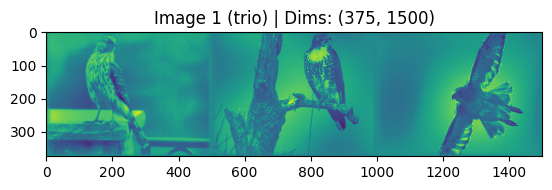

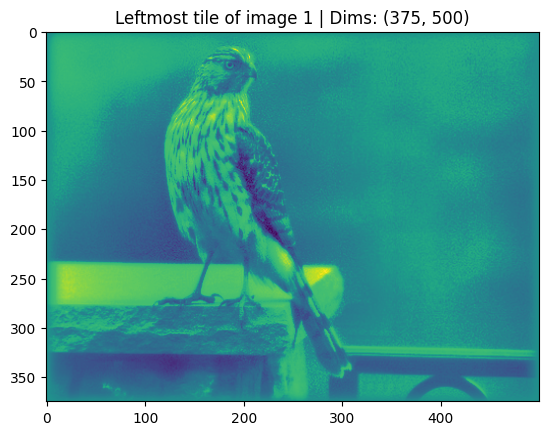

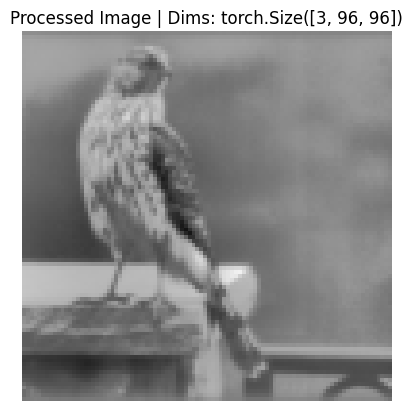

In [2]:
### Load and check the image data

PATH_TO_DATA = '../../data/selection1866'

file_1 = loadmat(os.path.join(PATH_TO_DATA, 'img1.mat'))
raw_img_1 = file_1['img']

plt.imshow(raw_img_1)
plt.title("Image 1 (trio) | Dims: {}".format(raw_img_1.shape))
plt.show()

img_1_tile_1 = raw_img_1[:, :500]

plt.imshow(img_1_tile_1)
plt.title("Leftmost tile of image 1 | Dims: {}".format(img_1_tile_1.shape))
plt.show()

# Visualise the transformations we will apply
transform = Compose([
    Resize(96), # Resize shortest edge to 96
    CenterCrop((96, 96)), # Crop to (224, 224)
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # Normalize
])

rgb_img = np.stack([img_1_tile_1] * 3, axis=-1) # Convert to RGB
tensor = torch.tensor(rgb_img, dtype=torch.float32).permute(2, 0, 1) # Shape (C, H, W)
tensor = (tensor + 2) / 4.0  # Scale to [0, 1]
tensor = torch.clamp(tensor, 0.0, 1.0)  # Clamp to ensure [0, 1] range
processed_img = transform(tensor) # Resize, crop, normalize

plt.imshow((processed_img * 0.5 + 0.5).permute(1, 2, 0).clamp(0, 1).numpy())
plt.title("Processed Image | Dims: {}".format(processed_img.shape))
plt.axis('off')
plt.show()

Labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Processed dataset shape: torch.Size([1866, 3, 224, 224])
Min pixel value (processed): -0.9981953501701355
Max pixel value (processed): 0.9988274574279785


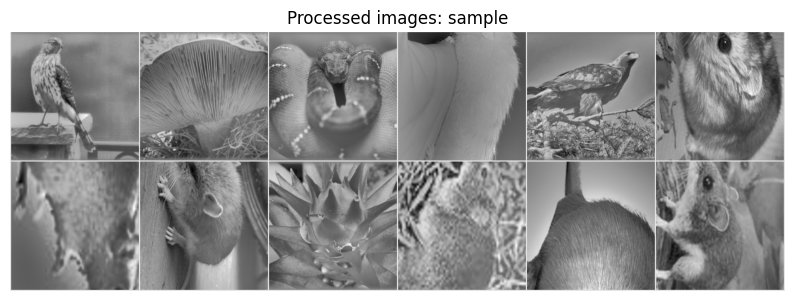

In [3]:
### Preprocess images for SimCLR

file_list = sorted(f for f in os.listdir(PATH_TO_DATA) if f.endswith('.mat'))

# Prepare images for SimCLR; todo: STL10 is 96x96
transform = Compose([
    Resize(224), # Resize shortest edge to 224 (cut off the rightmost part of the image)
    CenterCrop((224, 224)), # Crop to (224, 224)
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # !! Normalize expects input is already in the range [0, 1]
])

img_tensors,labels = [], []
for idx, filename in enumerate(file_list):
    data = loadmat(os.path.join(PATH_TO_DATA, filename))
    
    img = data['img'][:, :500] # Take leftmost part of the image
    rgb_img = np.stack([img] * 3, axis=-1) # Convert grayscale to RGB for SimCLR
    tensor = torch.tensor(rgb_img, dtype=torch.float32).permute(2, 0, 1) # Shape (C, H, W)
    
    # Min-max scale the tensor to [0, 1]
    tensor_min = tensor.min()
    tensor_max = tensor.max()
    tensor = (tensor - tensor_min) / (tensor_max - tensor_min)

    # Clamp to [0, 1] to ensure no outliers due to numerical precision
    tensor = torch.clamp(tensor, 0.0, 1.0)

    transformed_tensor = transform(tensor) # Normalize and resize for SimCLR
    img_tensors.append(transformed_tensor)
    labels.append(idx)

image_dataset = TensorDataset(torch.stack(img_tensors), torch.tensor(labels))

dataset = TensorDataset(torch.stack(img_tensors), torch.tensor(labels))

images, labels = dataset.tensors
print("Labels:", labels[:10])
print("Processed dataset shape:", images.shape) # (N, C, 96, 96)
print(f"Min pixel value (processed): {torch.min(images)}")
print(f"Max pixel value (processed): {torch.max(images)}")

# Show a sample of processed images
img_grid = torch_utils.make_grid(images[:12], nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0).numpy()
plt.figure(figsize=(10, 5))
plt.title('Processed images: sample')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [4]:
### Extract feature representations of our images from a pretrained SimCLR model

MODEL_CHECKPOINT_PATH = "../../models/tutorial17/SimCLR.ckpt"

NUM_WORKERS = os.cpu_count()
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

class SimCLR(pl.LightningModule):
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(num_classes=4*hidden_dim)  # Output of last linear layer
        
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc, # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

# Function to register hooks and capture outputs from intermediate layers
def register_hooks(model, layers):
    features = {}

    def hook(module, input, output, layer_name):
        features[layer_name] = output.detach()

    for layer_name in layers:
        layer = dict([*model.named_modules()])[layer_name]
        layer.register_forward_hook(lambda module, input, output, layer_name=layer_name: hook(module, input, output, layer_name))
    
    return features

# Run the pretrained SimCLR model on the experiment images, and capture features from final layer and intermediate layers
@torch.no_grad()
def extract_simclr_features(model, dataset, layers_to_capture):
    # Prepare model and register hooks
    network = deepcopy(model.convnet)
    network.fc = nn.Identity() # Removing projection head g(.)
    network.eval()
    network.to(device)
    
    # Register hooks to capture specific intermediate layers
    features = register_hooks(network, layers_to_capture)
    
    # Encode all images
    data_loader = DataLoader(dataset, batch_size=64, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)
    feats, labels, intermediate_features = [], [], {layer: [] for layer in layers_to_capture}
    
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)
        
        # Collect intermediate layer outputs
        for layer in layers_to_capture:
            # Final linear layer outputs a 2d tensor; but intermediate layers don't, so we flatten them ready for PCA 
            layer_output_flattened = features[layer].view(features[layer].size(0), -1) 
            intermediate_features[layer].append(layer_output_flattened.cpu())
    
    # Concatenate results for each layer
    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    intermediate_features = {layer: torch.cat(intermediate_features[layer], dim=0) for layer in layers_to_capture}
    
    return TensorDataset(feats, labels), intermediate_features

# Load the pretrained SimCLR model
model = SimCLR.load_from_checkpoint(MODEL_CHECKPOINT_PATH)
model.eval()

# Extract SimCLR representations and intermediate features
layers_to_capture = ['layer1', 'layer2', 'layer3', 'layer4']
final_layer, intermediate_features = extract_simclr_features(model, dataset, layers_to_capture)
final_layer_feats, labels = final_layer.tensors
layer1_feats = intermediate_features['layer1']
layer2_feats = intermediate_features['layer2']
layer4_feats = intermediate_features['layer4']

Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../models/tutorial17/SimCLR.ckpt`


Device: cpu
Number of workers: 10


  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
### Visualise SimCLR feature representations in pixel space

# Single image tensor (already extracted)
img_1 = images[0]

# Define the layers you want to capture
layers_to_capture = ['layer1', 'layer2', 'layer3', 'layer4']

# Function to register hooks for specified layers
def register_hooks(model, layers):
    features = {}

    def hook(module, input, output, layer_name):
        features[layer_name] = output.detach()

    for layer_name in layers:
        layer = dict([*model.named_modules()])[layer_name]
        layer.register_forward_hook(lambda module, input, output, layer_name=layer_name: hook(module, input, output, layer_name))
    
    return features

# Ensure img_1 is a tensor in the correct format
# Assuming img_1 is already a PyTorch tensor with shape (C, H, W) or (1, C, H, W)
if img_1.ndim == 3:  # If shape is (C, H, W), add batch dimension
    img_tensor = img_1.unsqueeze(0)
elif img_1.ndim == 4:  # If shape is already (1, C, H, W), no changes are needed
    img_tensor = img_1
else:
    raise ValueError("img_1 must have shape (C, H, W) or (1, C, H, W)")

# Ensure the tensor is normalized for SimCLR
# Normalize from [0, 1] to [-1, 1] if necessary
if img_tensor.max() > 1 or img_tensor.min() < -1:
    img_tensor = (img_tensor * 2) - 1  # Scale [0, 1] to [-1, 1]

# Load the SimCLR model, remove the projection head, and copy its encoder
model.eval()
network = deepcopy(model.convnet)
network.fc = torch.nn.Identity()  # Remove projection head
network.eval()
network.to(device)

# Register hooks and capture features
features = register_hooks(network, layers_to_capture)

# Pass the image through the network
img_tensor = img_tensor.to(device)
feats = network(img_tensor)  # Forward pass

# Visualize all feature maps layer-by-layer, row-by-row
def plot_feature_maps(features, max_maps_per_layer=16):
    """
    Plot feature maps layer-by-layer.
    Each layer's feature maps appear in a separate figure.
    """
    for layer_name, layer_output in features.items():
        layer_output = layer_output.squeeze(0).cpu()  # Remove batch dimension
        num_maps = layer_output.shape[0]  # Number of feature maps for the current layer
        
        # Limit the number of maps displayed per layer
        maps_to_plot = min(num_maps, max_maps_per_layer)

        # Create a new figure for each layer
        plt.figure(figsize=(maps_to_plot * 2, 4))
        for i in range(maps_to_plot):
            plt.subplot(1, maps_to_plot, i + 1)  # 1 row, multiple columns
            plt.imshow(layer_output[i].numpy(), cmap='viridis')
            plt.axis("off")
            plt.title(f"Map {i}")
        plt.suptitle(f"Feature Maps for {layer_name}")
        plt.tight_layout()
        plt.show()

# Call the function with the captured features
plot_feature_maps(features)

# Show the original image
plt.figure(figsize=(4, 4))
plt.imshow(img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy(), cmap='gray' if img_tensor.shape[1] == 1 else None)
plt.axis("off")
plt.title("Original Image")
plt.show()

In [ ]:
### Visualise feature representations from SimCLR layers

import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from copy import deepcopy
import random

def total_variation_loss(image):
    """
    Total variation loss to smooth the optimized image.
    """
    tv_loss = torch.sum(torch.abs(image[:, :, :-1, :] - image[:, :, 1:, :])) + \
              torch.sum(torch.abs(image[:, :, :, :-1] - image[:, :, :, 1:]))
    return tv_loss


def visualize_random_filters(model, layers, num_filters=10, input_size=(96, 96), iterations=200, lr=0.005):
    """
    Visualize patterns that maximize activation for a random selection of filters in specified layers.

    Args:
        model: The SimCLR model (PyTorch).
        layers: List of layer names to visualize (e.g., ['layer1', 'layer2', 'layer3', 'layer4']).
        num_filters: Number of random filters to visualize per layer.
        input_size: Size of the input image (default: 96x96).
        iterations: Number of optimization steps (default: 200).
        lr: Learning rate for optimization (default: 0.005).
    """
    # Prepare the model
    network = deepcopy(model.convnet)
    network.fc = torch.nn.Identity()  # Remove the projection head
    network.eval().to(device)

    # Iterate over each layer
    for layer_name in layers:
        # Hook to capture the output of the target layer
        activations = {}

        def hook(module, input, output):
            activations["layer_output"] = output

        target_layer = dict([*network.named_modules()])[layer_name]
        target_layer.register_forward_hook(hook)

        # Determine the number of filters in the layer
        _ = network(torch.randn(1, 3, *input_size, device=device))  # Forward pass to populate hook
        total_filters = activations["layer_output"].shape[1]

        # Select random filters
        random_filters = random.sample(range(total_filters), num_filters)
        print(f"Visualizing {num_filters} filters from {layer_name} (Randomly chosen: {random_filters})")

        # Create a figure to display all filter visualizations
        rows = 5 
        cols = 10
        fig, axes = plt.subplots(rows, cols, figsize=(15, 7))
        fig.suptitle(f"{layer_name} Filter Visualizations", fontsize=16)

        # Optimize and visualize each filter
        for idx, filter_index in enumerate(random_filters):
            # Start with a random noise image
            input_img = torch.randn(1, 3, *input_size, requires_grad=True, device=device)

            # Optimizer to modify the input image
            optimizer = torch.optim.Adam([input_img], lr=lr)

            for _ in range(iterations):
                optimizer.zero_grad()
                _ = network(input_img)  # Forward pass
                layer_output = activations["layer_output"]

                # Maximize activation and add regularization
                loss = -layer_output[0, filter_index].mean() + 0.01 * total_variation_loss(input_img)
                loss.backward() # backprop, computes how much each tensor contributed to final lsos
                optimizer.step()

            # Normalize the resulting image for visualization
            input_img = input_img.detach().cpu().squeeze()
            input_img = (input_img - input_img.min()) / (input_img.max() - input_img.min())
            
            # Display the optimized image
            # axes[idx].imshow(ToPILImage()(input_img),  cmap="gray")
            # axes[idx].axis("off")
            # axes[idx].set_title(f"Filter {filter_index}")
            row, col = divmod(idx, cols)
            axes[row, col].imshow(ToPILImage()(input_img), cmap="gray")
            axes[row, col].axis("off")
            axes[row, col].set_title(f"Filter {filter_index}", fontsize=8)

        plt.tight_layout()
        plt.show()

# Example usage
layers_to_visualize = ["fc"]  # Add 'fc' for the final layer
visualize_random_filters(model, layers=layers_to_visualize, num_filters=10, input_size=(96, 96), iterations=500, lr=0.01)

In [ ]:
# Try to speed it up
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from copy import deepcopy
import random

# Set device for M1 acceleration
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

def total_variation_loss(image):
    """ Regularization loss to encourage smoothness in generated images. """
    tv_loss = torch.sum(torch.abs(image[:, :, :-1, :] - image[:, :, 1:, :])) + \
              torch.sum(torch.abs(image[:, :, :, :-1] - image[:, :, :, 1:]))
    return tv_loss

def visualize_filters(model, layer_name, num_filters=10, input_size=(96, 96), iterations=200, lr=0.01):
    """ 
    Visualize synthetic features that maximize activation of filters in a given layer. 
    """
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = torch.nn.Identity()  # Remove projection head
    network.eval().to(device)

    # Hook to capture activations
    activations = {}

    def hook(module, input, output):
        activations["layer_output"] = output

    target_layer = dict([*network.named_modules()])[layer_name]
    target_layer.register_forward_hook(hook)

    # Run dummy forward pass to get layer output shape
    _ = network(torch.randn(1, 3, *input_size, device=device))
    total_filters = activations["layer_output"].shape[1]

    # Select random filters
    selected_filters = random.sample(range(total_filters), num_filters)
    print(f"Visualizing {num_filters} filters from {layer_name} (Selected: {selected_filters})")

    # Prepare figure
    rows, cols = (num_filters // 10) + 1, min(num_filters, 10)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 7))
    fig.suptitle(f"{layer_name} Filter Visualizations", fontsize=16)

    # Optimize input image for each filter
    for idx, filter_index in enumerate(selected_filters):
        # Initialize input image closer to natural images (reduces noise)
        input_img = (torch.randn(1, 3, *input_size, device=device) * 0.2).requires_grad_(True)

        optimizer = torch.optim.Adam([input_img], lr=lr)

        for _ in range(iterations):
            optimizer.zero_grad()
            _ = network(input_img)
            layer_output = activations["layer_output"]

            # Loss: maximize activation of specific filter + regularization
            loss = -layer_output[0, filter_index].mean() + 0.01 * total_variation_loss(input_img)
            loss.backward()
            optimizer.step()

        # Normalize for visualization
        img = input_img.detach().cpu().squeeze()
        img = (img - img.min()) / (img.max() - img.min())

        # Display result
        row, col = divmod(idx, cols)
        axes[row, col].imshow(ToPILImage()(img), cmap="gray")
        axes[row, col].axis("off")
        axes[row, col].set_title(f"Filter {filter_index}", fontsize=8)

    plt.tight_layout()
    plt.show()

# Run visualization for a specific layer
visualize_filters(model, layer_name="layer3", num_filters=20, input_size=(96, 96), iterations=300, lr=0.01)


Filters sorted by activation variability (top 10):
Filter 150: Variance = 28.695124
Filter 116: Variance = 22.668385
Filter 236: Variance = 12.087730
Filter 134: Variance = 12.006798
Filter 244: Variance = 10.250396
Filter 239: Variance = 9.221184
Filter 110: Variance = 7.636278
Filter 145: Variance = 7.632918
Filter 151: Variance = 4.537350
Filter 195: Variance = 4.303740
Pooled Activations Stats for Filter 116: min 0.000000, max 1.000000, mean 0.350944
Top image indices: [ 165  975 1599 1555 1471 1515 1719  711  567  819]
Bottom image indices: [ 440  872  441 1125  873  875  884 1112  193  324]


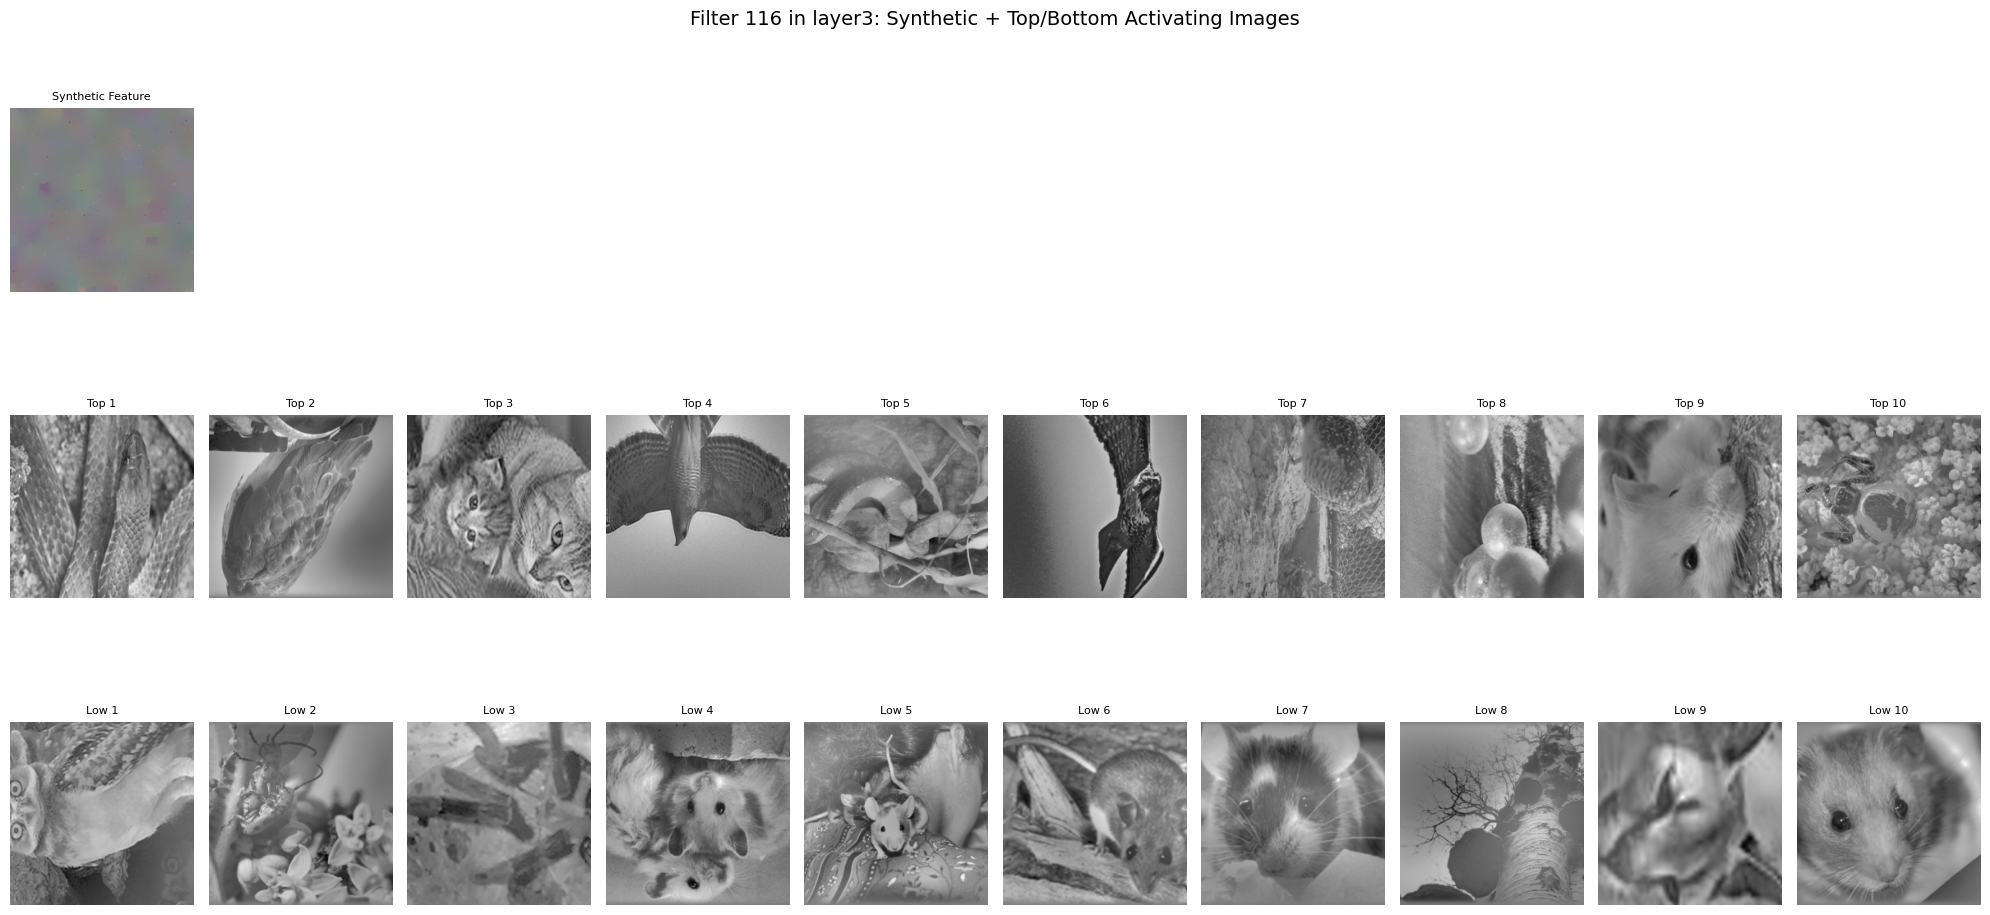

In [20]:
import os
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage, Compose, Resize, CenterCrop, Normalize
from torch.utils.data import TensorDataset, DataLoader
from copy import deepcopy
import random
from tqdm import tqdm

# ------------------------------
# Preprocessing (as used for training)
# ------------------------------
transform_visualization = Compose([
    Resize(224),
    CenterCrop((224, 224)),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def preprocess_for_display(tensor):
    """
    Undo normalization for display, ensuring values are in [0,1].
    """
    device = tensor.device  
    mean = torch.tensor([0.5, 0.5, 0.5], device=device).view(3, 1, 1)
    std = torch.tensor([0.5, 0.5, 0.5], device=device).view(3, 1, 1)
    tensor = tensor * std + mean
    tensor = torch.clamp(tensor, 0.0, 1.0)
    return tensor

def total_variation_loss(image):
    """Total variation loss to smooth the optimized image."""
    tv_loss = torch.sum(torch.abs(image[:, :, :-1, :] - image[:, :, 1:, :])) + \
              torch.sum(torch.abs(image[:, :, :, :-1] - image[:, :, :, 1:]))
    return tv_loss

# ------------------------------
# Compute variability of each filter
# ------------------------------
def get_filter_variability(layer_output):
    """
    Given layer_output of shape [N, num_filters, H, W],
    compute the variance of the pooled activations (using max pooling) for each filter across images.
    Returns:
        variability_dict: dict mapping filter index to variance value.
    """
    N, num_filters, H, W = layer_output.shape
    variability_dict = {}
    
    # For each filter f, pool over spatial dimensions (using sequential max)
    for f in range(num_filters):
        pooled = layer_output[:, f].max(dim=1)[0].max(dim=1)[0]  # Shape: [N]
        variability = pooled.var()
        variability_dict[f] = variability.item()
    
    return variability_dict

# ------------------------------
# Main function: Visualize a chosen filter's synthetic feature + top and bottom images
# ------------------------------
def visualize_filter_with_real_images(model, layer_name, filter_index, dataset, input_size=(224, 224), iterations=300, lr=0.01):
    """
    For a given filter in a specified layer, this function:
      - Computes activations for all images in the dataset.
      - Computes variability (and prints a sorted list of filters by variability).
      - Retrieves the top 10 and bottom 10 images activating the chosen filter.
      - Optimizes a synthetic image via gradient ascent for that filter.
      - Displays a grid: synthetic feature (first row), top activating images (second row), bottom activating images (third row).
      
    Args:
        model: Trained SimCLR model.
        layer_name: Target layer name (e.g., "layer3").
        filter_index: The index of the filter to visualize.
        dataset: A PyTorch tensor of shape [N, C, H, W] with your preprocessed images.
        input_size: Size for the synthetic image.
        iterations: Number of gradient ascent iterations.
        lr: Learning rate.
    """
    # Use mps if available, otherwise CPU.
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    
    # Create a copy of the visual model and remove the projection head.
    network = deepcopy(model.convnet)
    network.fc = torch.nn.Identity()
    network.eval().to(device)
    
    # Register a hook to capture the target layer's output.
    activations = {}
    def hook(module, input, output):
        activations["layer_output"] = output.clone().detach()
    target_layer = dict([*network.named_modules()])[layer_name]
    handle = target_layer.register_forward_hook(hook)
    
    # Move dataset to device and compute activations for all images.
    dataset = dataset.to(device)
    with torch.no_grad():
        _ = network(dataset)
        layer_output = activations["layer_output"]  # Shape: [N, num_filters, H, W]
    
    # Compute variability for each filter.
    variability_dict = get_filter_variability(layer_output)
    sorted_filters = sorted(variability_dict.items(), key=lambda x: x[1], reverse=True)
    print("Filters sorted by activation variability (top 10):")
    for f, var in sorted_filters[:10]:
        print(f"Filter {f}: Variance = {var:.6f}")
    
    handle.remove()  # Remove hook to avoid stacking.
    
    # For the chosen filter, compute pooled activations using max pooling over spatial dims.
    pooled_activations = layer_output[:, filter_index].max(dim=1)[0].max(dim=1)[0]  # [N]
    pooled_activations = (pooled_activations - pooled_activations.min()) / (pooled_activations.max() - pooled_activations.min() + 1e-8)
    
    print(f"Pooled Activations Stats for Filter {filter_index}: min {pooled_activations.min().item():.6f}, max {pooled_activations.max().item():.6f}, mean {pooled_activations.mean().item():.6f}")
    
    # Rank images: top 10 and bottom 10 indices.
    top_indices = torch.argsort(pooled_activations, descending=True)[:10]
    bottom_indices = torch.argsort(pooled_activations)[:10]
    print("Top image indices:", top_indices.cpu().numpy())
    print("Bottom image indices:", bottom_indices.cpu().numpy())
    
    # Retrieve and preprocess the top and bottom images.
    # (They are assumed to have been preprocessed already; here we undo normalization for display.)
    top_images = torch.stack([preprocess_for_display(dataset[i].to(device)) for i in top_indices]).cpu()
    bottom_images = torch.stack([preprocess_for_display(dataset[i].to(device)) for i in bottom_indices]).cpu()
    
    # -------------------------------
    # Synthetic feature visualization via gradient ascent.
    # -------------------------------
    input_img = torch.randn(1, 3, *input_size, requires_grad=True, device=device)
    optimizer = torch.optim.Adam([input_img], lr=lr)
    for _ in range(iterations):
        optimizer.zero_grad()
        _ = network(input_img)
        layer_out = activations["layer_output"]  # This will be updated with the synthetic image.
        loss = -layer_out[0, filter_index].mean() + 0.01 * total_variation_loss(input_img)
        loss.backward()
        optimizer.step()
    
    synthetic_img = preprocess_for_display(input_img.detach().cpu().squeeze())
    
    # -------------------------------
    # Visualization grid: 3 rows x 10 columns.
    # Row 0: Synthetic feature (first cell)
    # Row 1: Top 10 activating images.
    # Row 2: Bottom 10 activating images.
    # -------------------------------
    fig, axes = plt.subplots(3, 10, figsize=(20, 10))
    fig.suptitle(f"Filter {filter_index} in {layer_name}: Synthetic + Top/Bottom Activating Images", fontsize=14)
    
    # Display synthetic feature in the first cell of row 0.
    axes[0, 0].imshow(ToPILImage()(synthetic_img), cmap="gray")
    axes[0, 0].set_title("Synthetic Feature", fontsize=8)
    axes[0, 0].axis("off")
    # (You can leave the rest of row 0 blank or replicate the synthetic feature.)
    for j in range(1, 10):
        axes[0, j].axis("off")
    
    # Display top activating images in row 1.
    for i in range(10):
        axes[1, i].imshow(ToPILImage()(top_images[i]), cmap="gray")
        axes[1, i].set_title(f"Top {i+1}", fontsize=8)
        axes[1, i].axis("off")
    
    # Display bottom activating images in row 2.
    for i in range(10):
        axes[2, i].imshow(ToPILImage()(bottom_images[i]), cmap="gray")
        axes[2, i].set_title(f"Low {i+1}", fontsize=8)
        axes[2, i].axis("off")
    
    plt.tight_layout()
    plt.show()

# Example usage:
layer_to_visualize = "layer3"
# Choose a filter index that, according to variability, is selective (e.g., one with high variance).
filter_to_visualize = 116  # You can change this based on the printed variability stats.
visualize_filter_with_real_images(model, layer_to_visualize, filter_to_visualize, dataset=images)

# Filters sorted by activation variability (top 10):
# Filter 150: Variance = 28.695124
# Filter 116: Variance = 22.668385
# Filter 236: Variance = 12.087730
# Filter 134: Variance = 12.006798
# Filter 244: Variance = 10.250396
# Filter 239: Variance = 9.221184
# Filter 110: Variance = 7.636278
# Filter 145: Variance = 7.632918
# Filter 151: Variance = 4.537350
# Filter 195: Variance = 4.303740